# Machine Learning Housing Corporation
### Goal: Build a model of housing prices in California using the California census data
The data includes metrics such as population, median income, median housing price, etc. for each block group (district) in California

## Fetch the data
Start by writting a function that fetches the data

In [1]:
import os
import tarfile
from six.moves import urllib

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

## Funtion to download the data from github
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url,tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
## Get the data
fetch_housing_data()

## Now load the data using Pandas
The following function will do it

In [129]:
import pandas as pd

## Read the csv into a dataframe
def load_housing_data(housing_path = HOUSING_PATH):
    cvs_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(cvs_path)

In [130]:
## Load it
housing = load_housing_data()

## A quick look at the schema
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [131]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


A quick look reveals 9 numerical features and one object feature. The `total_bedrooms` attribute is missing for 207 districs.

Let's look at the content of `ocean_proximity`

In [132]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [133]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## Draw histograms for each numerlcal attribute

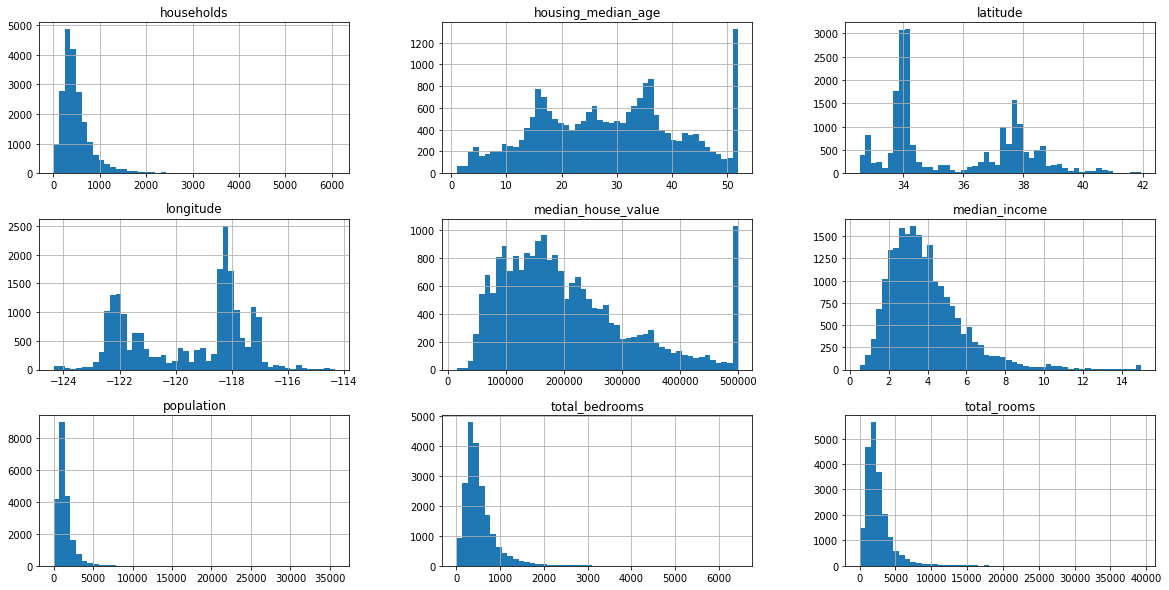

In [134]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,10))
plt.show()

## Create a test set
Using our own function that randomly chooses entries

In [135]:
import numpy as np

def split_train_set(data,test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [136]:
train_set, test_set = split_train_set(housing,0.2)
print len(train_set),"train +", len(test_set), "test"

16512 train + 4128 test


Or using `scikit-learn`'s function

In [137]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)
print len(train_set),"train +", len(test_set), "test"

16512 train + 4128 test


## Create new income feature
Divide by 1.5 (to limit the number of income categories and round up using `ceil` (to have discrete categories), and then merging all categories greater than 5 into category 5. This solves the problem of having a feature with a long tail


In [138]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"]<5,5.0,inplace=True)

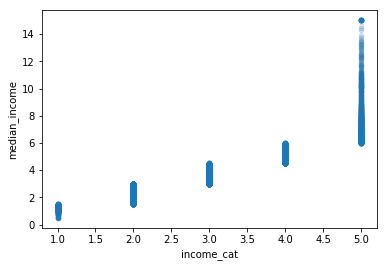

In [139]:
housing.plot(kind="scatter",x="income_cat",y="median_income",alpha=0.1)

## Stratified sampling based on the new income category
This avoids having a stratified test sample that won't scale later on for high income cases


In [140]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [141]:
strat_train_set["income_cat"].value_counts() / len(housing)

3.0    0.280475
2.0    0.255087
4.0    0.141037
5.0    0.091521
1.0    0.031880
Name: income_cat, dtype: float64


Remove the `income_cat` category so the data is back to original


In [142]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"],axis=1,inplace=True)

## Discover and visualize the data

Start by making a copy of it so we can play with it

In [143]:
housing = strat_train_set.copy()

### Just plot latitude and longitude

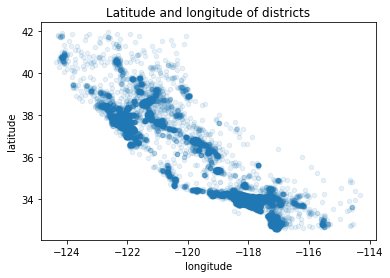

In [144]:
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.1)
plt.title("Latitude and longitude of districts")
plt.show()

### Now with more info: radius of circle represents population, colour represents the price

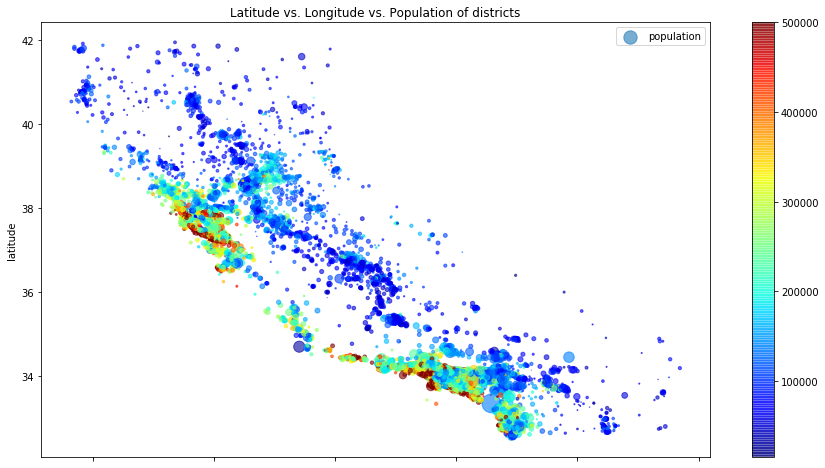

In [147]:
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.6,
            s = housing["population"]/100, label = "population",
            c = housing["median_house_value"], cmap = plt.get_cmap("jet"), colorbar=True,
            figsize=(15,8))
plt.title("Latitude vs. Longitude vs. Population of districts")
plt.legend()
plt.show()

## Looking for correlations

The `corr()` method calculates the standard correlation coefficient (Pearson's r) betweeen every pair

In [148]:
corr_matrix = housing.corr()

In [22]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

### Plot the scatter matrix for the most correlated features

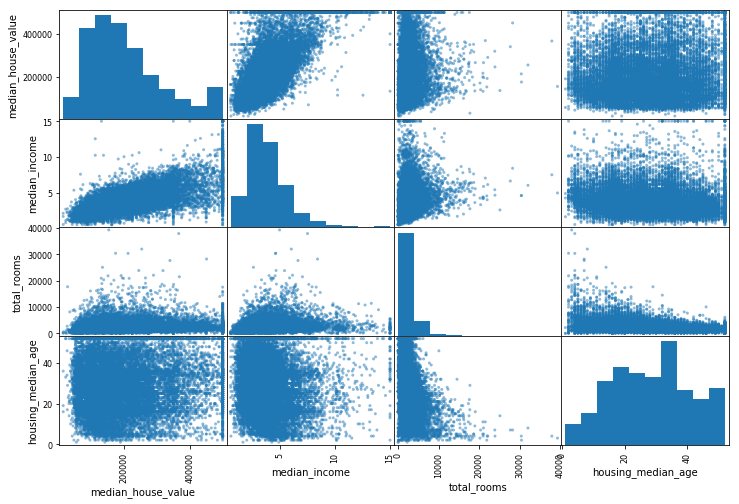

In [23]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value","median_income","total_rooms","housing_median_age"]
scatter_matrix(housing[attributes], figsize = (12,8))
plt.show()

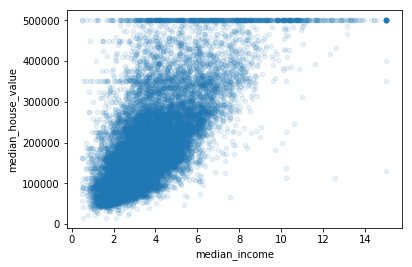

In [24]:
housing.plot(kind="scatter",y="median_house_value",x="median_income",alpha=0.1)
plt.show()

## Experimenting with attribute combinations
Compute attributes per household

In [25]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [26]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

# Prepare the Data for Machine Learning Algorithms
First, revert to a clean training set, and separate predictors and labels.

In [27]:
## Drop creates a copy and doesn't affect the original strat_train_set
housing = strat_train_set.drop("median_house_value",axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Data cleaning
Get rid of enties with missing values.

Could to do it with `dropna()`, `drop()` or with `fillna()` and filling with the median.

But the fanciest way of doing it is with the `Imputer` class of `scikit-learn`

In [28]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

In [29]:
## Create a copy of the data without the ocean_proximity as a median cannot be calculated for non-numerical features
housing_num = housing.drop("ocean_proximity",axis=1)

## And then fit the training data to the imputer, which will just calculate the medians
imputer.fit(housing_num)

## We can access them theough the "statistics_" instance variables
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [30]:
housing_num.median()

longitude             -118.5100
latitude                34.2600
housing_median_age      29.0000
total_rooms           2119.5000
total_bedrooms         433.0000
population            1164.0000
households             408.0000
median_income            3.5409
dtype: float64

In [31]:
## Finally we can use the trained imputer to apply the transformation of replacing NAs with the median
X = imputer.transform(housing_num)

In [32]:
## Put it back into a Pandas DataFrame
housing_tr = pd.DataFrame(X,columns=housing_num.columns)

In [33]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


## Handle text attributes
The `ocean_proximity` specifically

In [34]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [35]:
print encoder.classes_

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


It is better to do "Hot Encoding" which avoids having numerical values that might introduce biases (0 = OCEAN being close to 1 = INLAND)

In [36]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
## The -1 in reshape() is automatically replaced by the size of the array (16000 something)
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<type 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [37]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

### LabelBinarizer is the even smartest/fastest way

In [38]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer(sparse_output=True)
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<type 'numpy.int64'>'
	with 16512 stored elements in Compressed Sparse Row format>

## Custom transformers in Scikit-Learn
Needs three methods: 

`fit()`, `transform()`, and `fit_transform()` (which can get for free by adding `TransformerMixin` as a base class. 

Also, adding `BaseEstimator` as a base class adds two useful extra methods: `get_params()` and `set_params()` for automatic hyperparameter tuning

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs for BaseEstimator compat
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y = None):
        return self # Do nothing
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household,population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_atttribs = attr_adder.transform(housing.values)

In [40]:
housing_extra_atttribs

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

## Transformation pipeling (including feature scaling)
Let's use Scikit-Learn's `Pipeline` class

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([('imputer',Imputer(strategy="median")),
                        ('attribs_adder', CombinedAttributesAdder()),
                        ('std_scaler', StandardScaler()) 
                        ])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr_df = pd.DataFrame(housing_num_tr)
housing_num_tr_df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,-0.312055,-0.086499,0.155318
1,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459,0.217683,-0.033534,-0.836289
2,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046,-0.465315,-0.092405,0.422200
3,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566,-0.079661,0.089736,-0.196453
4,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437,-0.357834,-0.004194,0.269928


### FeatureUnion
To join the transformations for numerical attributes with the categorical attributes.

In [42]:
from sklearn.base import BaseEstimator, TransformerMixin

## First define a DataFrameSelector() custom transformer since Scikit-Learn doesnt handle Pandas DataFrames
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes_names):
        self.attributes_names = attributes_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attributes_names].values

In [43]:
## This function will be added to v0.20 of sklearn

# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out


In [44]:
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([('selector', DataFrameSelector(num_attribs)),
                        ('imputer',Imputer(strategy="median")),
                        ('attribs_adder', CombinedAttributesAdder()),
                        ('std_scaler', StandardScaler()) 
                        ])
cat_pipeline = Pipeline([('selector',DataFrameSelector(cat_attribs)),
                        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense"))
                        ])

## Can then join the pipelines
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline",num_pipeline),
    ("cat_pipeline",cat_pipeline),
])

In [45]:
## Then run the whole pipeline
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared
#housing_prepared.shape

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

# Select and Train a Model!!!
### Start with a Linear Regression

In [46]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)

/Users/elder/my-virtualenv/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### Let's try it on a few instances from the training set

In [47]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("Labels:\t", list(some_labels))

('Predictions:\t', array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879]))
('Labels:\t', [286600.0, 340600.0, 196900.0, 46300.0, 254500.0])


### Now let's measure the RMSE
We can use sklearn's `mean_squared_error`

In [48]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels,housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

In [49]:
print "m = %.2f" % lin_reg.coef_[0]
print "b = %.2f" % lin_reg.intercept_


m = -55650.41
b = 236915.00


In [51]:
## Plot some scatter plots
housing_labels.head()
housing_prepared
#plt.scatter(housing_labels, housing_prepared["total_bedrooms"], color="black")

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

I want to plot scatter plots with their respective linear model prediction, figure out how to do it!!

## Now try a `DecisionTreeRegressor`

The resulting RMSE is 0.0. Obviously, this is a bad case of overfitting.

In [52]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared,housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [53]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels,housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

## k-fold cross-validation using `cross_val_score`

It splits the training set into k different subsets (folds) and trains and evaluates the model 10 times, picking a different fold for evaluation each time.

In [60]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

In [61]:
## A function to display the scores using numpy functionalities
def display_scores(scores):
    print("Scores: ", scores)
    print("Means: ", scores.mean())
    print("Standard deviation: ", scores.std())
    
display_scores(rmse_scores)

('Scores: ', array([69198.95698095, 66722.34705686, 71366.16351102, 68418.60337202,
       72211.24696204, 73757.71266046, 69809.35734053, 70717.89307014,
       76119.7564573 , 69833.6494981 ]))
('Means: ', 70815.56869094231)
('Standard deviation: ', 2571.7931119576992)


Now for the linear regression model

In [62]:
lin_scores = cross_val_score(lin_reg,housing_prepared,housing_labels,scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

('Scores: ', array([66782.73843989, 66960.118071  , 70347.69336202, 74740.49462253,
       68033.20808411, 71195.28268849, 64969.63056405, 68272.42890025,
       71541.56591766, 67665.10082067]))
('Means: ', 69050.82614706854)
('Standard deviation: ', 2731.1132046553917)


So the `DecisionTree` overfits so badly to the point that the `LinearRegression` model is actually better.

### Now a `RandomForestRegressor`

This is an example of *EnsembleLearning*

In [63]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_scores = cross_val_score(forest_reg,housing_prepared,housing_labels,scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

('Scores: ', array([51923.87690053, 49899.70220871, 52253.29964114, 54455.97738245,
       52566.78709793, 55683.39813307, 50556.25753914, 50815.5506586 ,
       54975.14776773, 53230.05193545]))
('Means: ', 52636.004926474685)
('Standard deviation: ', 1849.5546070629857)


### Now time to fine tune the model. Start with `GridSearchCV`

I'll try it with a few parameters

In [150]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators':[3,10,30], 'max_features':[2,4,6,8]}]

grid_forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [151]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [159]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [160]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"],cvres["params"]):
    print(np.sqrt(-mean_score), params)

(63619.01973875702, {'max_features': 2, 'n_estimators': 3})
(55386.77651230173, {'max_features': 2, 'n_estimators': 10})
(53103.8296706632, {'max_features': 2, 'n_estimators': 30})
(59970.00244744011, {'max_features': 4, 'n_estimators': 3})
(52637.295846912515, {'max_features': 4, 'n_estimators': 10})
(50519.19575465062, {'max_features': 4, 'n_estimators': 30})
(58504.88280406442, {'max_features': 6, 'n_estimators': 3})
(52292.02539323387, {'max_features': 6, 'n_estimators': 10})
(50087.67789803854, {'max_features': 6, 'n_estimators': 30})
(58017.49081733406, {'max_features': 8, 'n_estimators': 3})
(52525.65038643209, {'max_features': 8, 'n_estimators': 10})
(49925.926437990056, {'max_features': 8, 'n_estimators': 30})


So the best combination is indeed `max_features` = 8 with `n_estimators` = 30

### Now try `RandomizedSearch` (Part of Ex. 1)

This chooses a set number of throws for the hyperparameters and finds the best option

In [161]:
xyz = np.random.random((1000,3))


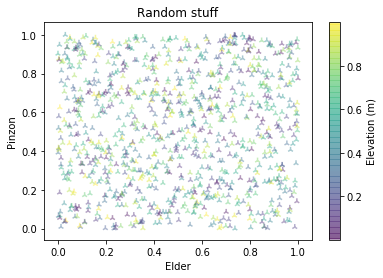

In [162]:
plt.scatter(xyz[:,0],xyz[:,1],c=xyz[:,2],marker="2",alpha=0.4)
cbar = plt.colorbar()
cbar.set_label("Elevation (m)")
plt.title("Random stuff")
plt.xlabel("Elder")
plt.ylabel("Pinzon")
plt.show()

### Analysing the best models
The relative importance of each attribute for making accurate predictions

In [183]:
## Grab the feature importances from the grid_search object
feature_importances = grid_search.best_estimator_.feature_importances_

extra_attribs = ["rooms_per_household", "population_per_household", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
list_feature_importance = sorted(zip(feature_importances, attributes), reverse=True)

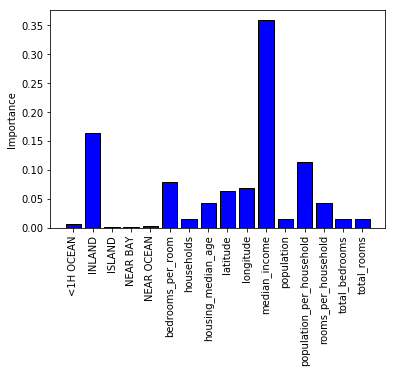

In [216]:
## Plot a histogram from this list
f = plt.figure()
plt.bar(attributes,feature_importances, color='blue',edgecolor='black')
plt.xticks(rotation=90)
plt.ylabel("Importance")
plt.show()
f.savefig("feature-importances.pdf")

A few features could be dropped! But clearly **the median income is the number one predictor of housing prices!!!**

## Finally, evaluate the system of the test set

In [175]:
## Get the final model
final_model = grid_search.best_estimator_

In [180]:
## Get features and target label in the same way as before
housing_test = strat_test_set.drop("median_house_value",axis=1)
housing_test_labels = strat_test_set["median_house_value"].copy()

## Apply the transformation pipeline
housing_test_prepared = full_pipeline.transform(housing_test)

In [181]:
## Get predictions from model
final_predictions = final_model.predict(housing_test_prepared)

## Compute scores
final_mse = mean_squared_error(housing_test_labels, final_predictions)
final_rmse = np.sqrt(final_mse)

In [182]:
print final_rmse

47780.47942706931


### Result

The performace is slightly better in the test set (47780 vs 49925). In general, it should be the other way around